In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output

sns.set()

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/cleaned_taxi.csv")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/taxi_trip_data (1).csv')


In [ ]:
df.shape

(10000000, 17)

In [ ]:
with_dups = df.shape[0]
df.drop_duplicates(inplace=True)

print(f"{round((with_dups - df.shape[0]) / with_dups * 100, 2)}% of rows were duplicates")
print(f"Duplicates dropped with {df.shape[0]} rows remaining")

6.08% of rows were duplicates
Duplicates dropped with 9392429 rows remaining


In [ ]:
df.isna().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
total_amount           0
pickup_location_id     0
dropoff_location_id    0
dtype: int64

In [ ]:
def zero_cnt(df):
    print("Count of zeroes and empty strings:")
    print("column                   count     percentage")
    for col in df.columns:
        if df[col].dtype != 'object':
            cnt = df[df[col] == 0].shape[0]
        else:
            cnt = df[df[col] == ''].shape[0]
        print(f"{col:<25}{cnt:<10}{round(cnt/df.shape[0]*100, 2):<5}")

zero_cnt(df)

Count of zeroes and empty strings:
column                   count     percentage
vendor_id                0         0.0  
pickup_datetime          0         0.0  
dropoff_datetime         0         0.0  
passenger_count          85779     0.91 
trip_distance            264896    2.82 
rate_code                0         0.0  
store_and_fwd_flag       0         0.0  
payment_type             0         0.0  
fare_amount              12176     0.13 
extra                    5048008   53.75
mta_tax                  285657    3.04 
tip_amount               2062555   21.96
tolls_amount             6253748   66.58
imp_surcharge            12433     0.13 
total_amount             5725      0.06 
pickup_location_id       0         0.0  
dropoff_location_id      0         0.0  


In [ ]:
df = df[df['trip_distance'] != 0]
df = df[df['fare_amount'] != 0]
df = df[df['passenger_count'] != 0]

# Call zero_cnt function to count occurrences of zero values and empty strings in each column
zero_cnt(df)


Count of zeroes and empty strings:
column                   count     percentage
vendor_id                0         0.0  
pickup_datetime          0         0.0  
dropoff_datetime         0         0.0  
passenger_count          0         0.0  
trip_distance            0         0.0  
rate_code                0         0.0  
store_and_fwd_flag       0         0.0  
payment_type             0         0.0  
fare_amount              0         0.0  
extra                    4801203   53.1 
mta_tax                  214307    2.37 
tip_amount               1891064   20.92
tolls_amount             5948376   65.79
imp_surcharge            1410      0.02 
total_amount             0         0.0  
pickup_location_id       0         0.0  
dropoff_location_id      0         0.0  


In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [ ]:
df['weekday'] = df.pickup_datetime.dt.day_name()
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [ ]:
# Calculate trip durations

df['trip_duration'] = df['dropoff_datetime'] - df['pickup_datetime']


df['trip_duration_seconds'] = df['trip_duration'].dt.total_seconds()

In [ ]:
df = df[df['vendor_id'] != 4]

In [ ]:
pd.options.display.float_format = '{:.2f}'.format


In [ ]:
negative_trip_distances = df[df['trip_distance'] < 0]

# Count the number of negative values
num_negative_trip_distances = negative_trip_distances.shape[0]

# Print the number of negative values
print("Number of negative trip distances:", num_negative_trip_distances)


Number of negative trip distances: 0


In [ ]:
# Check for negative values in the 'trip_duration_seconds' column
negative_trip_durations = df[df['trip_duration_seconds'] < 0]

# Count the number of negative values
num_negative_trip_durations = negative_trip_durations.shape[0]

# Print the number of negative values
print("Number of negative trip durations:", num_negative_trip_durations)


Number of negative trip durations: 129


In [ ]:
# Remove rows with negative trip durations
df = df[df['trip_duration_seconds'] >= 0]

# Verify the removal by checking the number of negative trip durations
num_negative_trip_durations_after_removal = df[df['trip_duration_seconds'] < 0].shape[0]

# Print the number of negative trip durations after removal (should be 0)
print("Number of negative trip durations after removal:", num_negative_trip_durations_after_removal)


Number of negative trip durations after removal: 0


In [ ]:
# List of columns to check
columns_to_check = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Check for negative values in each column
for column in columns_to_check:
    negative_values = df[df[column] < 0]
    num_negative_values = negative_values.shape[0]
    print(f"Number of negative values in '{column}' column: {num_negative_values}")


Number of negative values in 'fare_amount' column: 22401
Number of negative values in 'extra' column: 11724
Number of negative values in 'mta_tax' column: 22122
Number of negative values in 'tip_amount' column: 294
Number of negative values in 'tolls_amount' column: 186
Number of negative values in 'imp_surcharge' column: 22398
Number of negative values in 'total_amount' column: 22401


In [ ]:
# List of columns with negative values
columns_with_negative_values = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Create a boolean mask for rows with any negative values in these columns
negative_mask = df[columns_with_negative_values].lt(0).any(axis=1)

# Remove rows with any negative values
df_cleaned = df[~negative_mask]

# Print the number of rows removed
num_rows_removed = sum(negative_mask)
print("Number of rows removed:", num_rows_removed)


Number of rows removed: 22412


In [ ]:
df.shape

(8996881, 23)

In [ ]:
# Select float and integer columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Check if any numeric column has negative values
negative_values = numeric_columns.lt(0).any()

# Print columns with negative values
print("Numeric columns with negative values:")
print(negative_values[negative_values].index.tolist())



Numeric columns with negative values:
['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']


In [ ]:
# Define the numeric columns with negative values
numeric_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Remove rows with negative values in specific numeric columns
df = df[(df[numeric_cols] >= 0).all(axis=1)]


In [ ]:
# Select float and integer columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Check if any numeric column has negative values
negative_values = numeric_columns.lt(0).any()

# Print columns with negative values
print("Numeric columns with negative values:")
print(negative_values[negative_values].index.tolist())

Numeric columns with negative values:
[]


In [ ]:
df.loc[:, 'speed'] = df['trip_distance'] / (df['trip_duration_seconds'] / 3600)


In [ ]:
# Check for negative values in the 'speed' column
negative_speed = df[df['speed'] < 0]

# Check for values above 150 in the 'speed' column
high_speed = df[df['speed'] > 150]

# Display the rows where 'speed' is negative
print("Rows with negative speed:")
print(negative_speed)

# Display the rows where 'speed' is above 150
print("\nRows with speed above 150:")
print(high_speed)


Rows with negative speed:
Empty DataFrame
Columns: [vendor_id, pickup_datetime, dropoff_datetime, passenger_count, trip_distance, rate_code, store_and_fwd_flag, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, imp_surcharge, total_amount, pickup_location_id, dropoff_location_id, weekday, month, weekday_num, pickup_hour, trip_duration, trip_duration_seconds, speed]
Index: []

[0 rows x 24 columns]

Rows with speed above 150:
         vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
154              1 2018-08-03 19:57:29 2018-08-03 19:57:30                1   
374              1 2018-07-23 17:50:26 2018-07-23 17:50:52                1   
1006             1 2018-09-17 15:34:41 2018-09-17 15:34:54                1   
1061             1 2018-03-12 16:34:21 2018-03-12 16:34:31                1   
2346             2 2018-12-15 23:17:27 2018-12-15 23:17:30                1   
...            ...                 ...                 ...              ...   

In [ ]:
# Remove rows with speed above 150
df = df[df['speed'] <= 150]


In [ ]:
less_than_1_mile = df[df['trip_distance'] < 1]
num_rows = less_than_1_mile.shape[0]
print("Number of rows with trip distance less than 1 mile:", num_rows)

Number of rows with trip distance less than 1 mile: 338543


In [ ]:
df.drop(less_than_1_mile.index, inplace=True)


In [ ]:
df.dtypes

vendor_id                          int64
pickup_datetime           datetime64[ns]
dropoff_datetime          datetime64[ns]
passenger_count                    int64
trip_distance                    float64
rate_code                          int64
store_and_fwd_flag                object
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
imp_surcharge                    float64
total_amount                     float64
pickup_location_id                 int64
dropoff_location_id                int64
weekday                           object
month                              int64
weekday_num                        int64
pickup_hour                        int64
trip_duration            timedelta64[ns]
trip_duration_seconds            float64
speed                            float64
dtype: object

In [ ]:
num_rows_equal_total_fare = len(df[df['total_amount'] == df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['imp_surcharge']])
print("Number of rows where total amount equals sum of fare components:", num_rows_equal_total_fare)


Number of rows where total amount equals sum of fare components: 5646201


In [ ]:
# Keep only the rows where total amount equals sum of fare components
df = df[df['total_amount'] == df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['imp_surcharge']]


In [ ]:
df.shape

(5646201, 24)

In [ ]:
df.describe

<bound method NDFrame.describe of          vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0                2 2018-03-29 13:37:13 2018-03-29 14:17:01                1   
1                2 2018-03-29 13:37:18 2018-03-29 14:15:33                1   
6                1 2018-03-29 14:09:41 2018-03-29 14:36:29                1   
7                2 2018-03-29 15:21:42 2018-03-29 16:04:16                1   
8                2 2018-03-29 15:14:59 2018-03-29 16:42:46                1   
...            ...                 ...                 ...              ...   
9999980          1 2018-06-19 16:11:42 2018-06-19 16:41:52                1   
9999983          1 2018-06-19 18:10:32 2018-06-19 18:41:58                1   
9999984          2 2018-06-19 20:14:05 2018-06-19 20:34:49                5   
9999985          1 2018-06-19 21:11:43 2018-06-19 21:39:34                1   
9999986          1 2018-06-19 21:54:36 2018-06-19 22:18:08                2   

         trip_dis

In [ ]:
df.dtypes

vendor_id                  int64
pickup_datetime           object
dropoff_datetime          object
passenger_count            int64
trip_distance            float64
rate_code                  int64
store_and_fwd_flag        object
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
imp_surcharge            float64
total_amount             float64
pickup_location_id         int64
dropoff_location_id        int64
weekday                   object
month                      int64
weekday_num                int64
pickup_hour                int64
trip_duration             object
trip_duration_seconds    float64
speed                    float64
dtype: object

In [ ]:
df.to_csv("/content/drive/MyDrive/cleaned_taxi.csv", index=False)


<ipython-input-3-c7af1682aa08>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot= True);


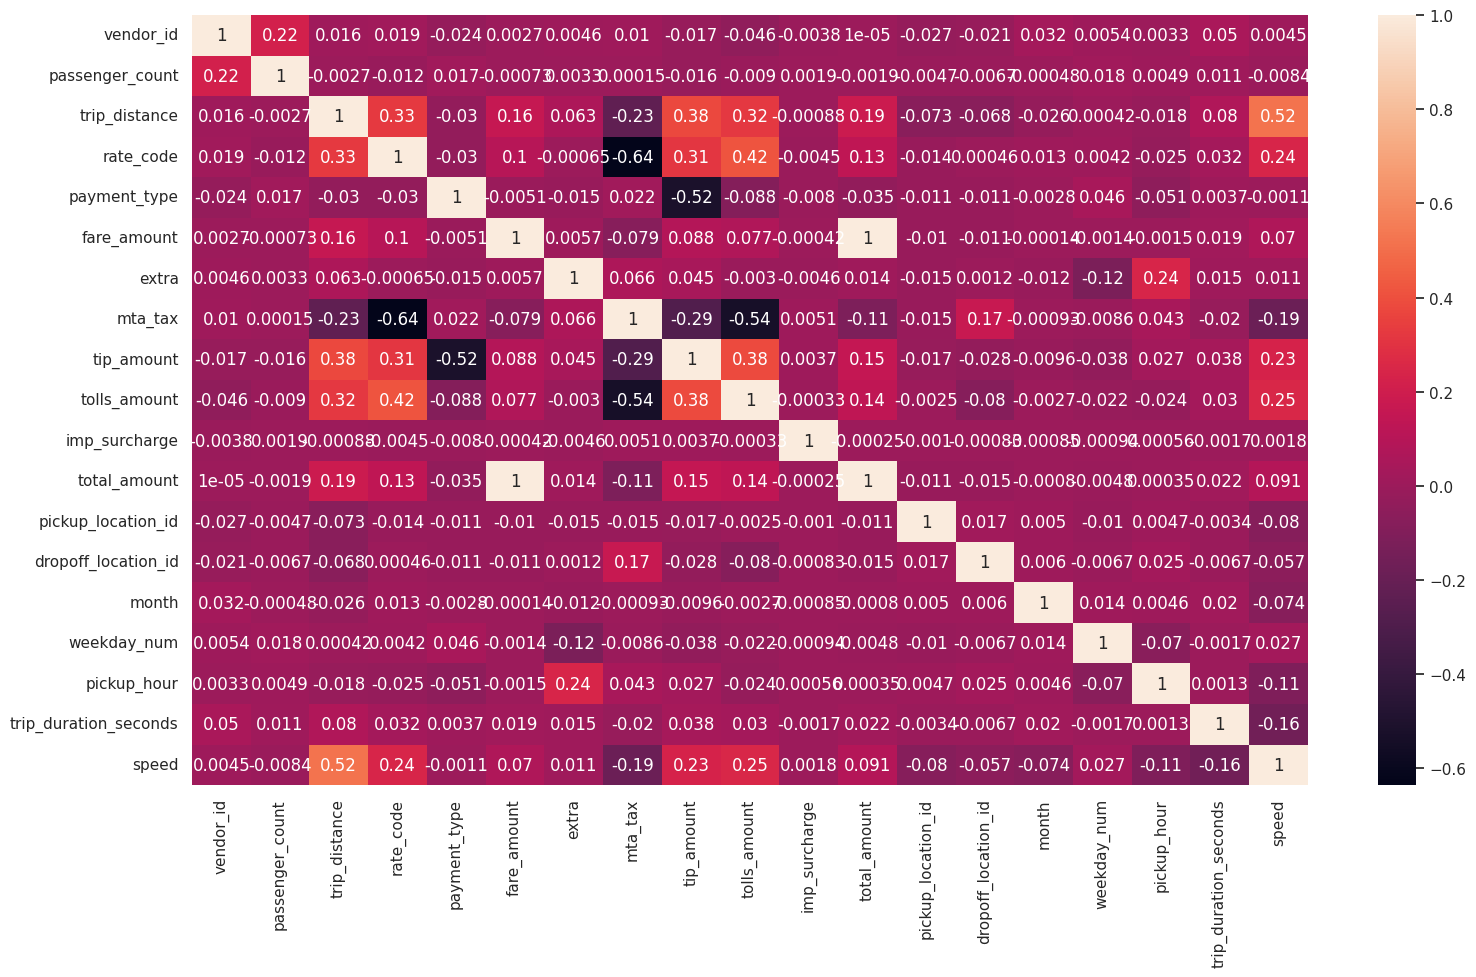

In [ ]:
plt.figure(figsize= (18, 10))
sns.heatmap(df.corr(), annot= True);

Mean Absolute Error: 3.3202227018697585
Root Mean Squared Error: 8.190438709668486
Mean squared error: 67.08328625683596
R2 Score: 0.8598242985666233


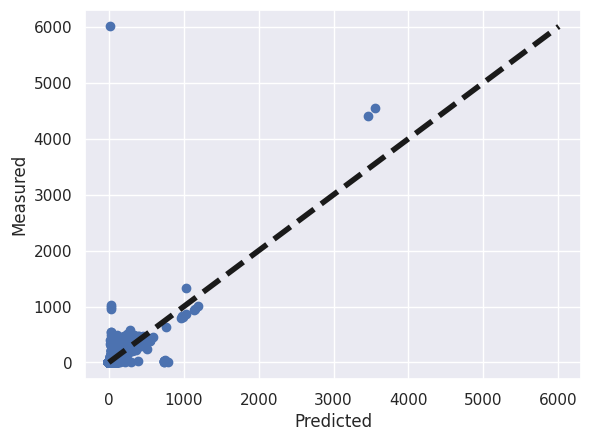

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df[['trip_distance', 'passenger_count', 'rate_code', 'trip_duration_seconds','speed','tolls_amount','tip_amount']]
y = df['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,y_pred)))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))
plt.plot(y_pred, y_test, 'o')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw= 4)
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.show()

Mean Absolute Error: 0.759147807848962
Root Mean Squared Error: 6.981140568554039
Mean squared error: 48.73632363791101
R2 Score: 0.8981616922422003


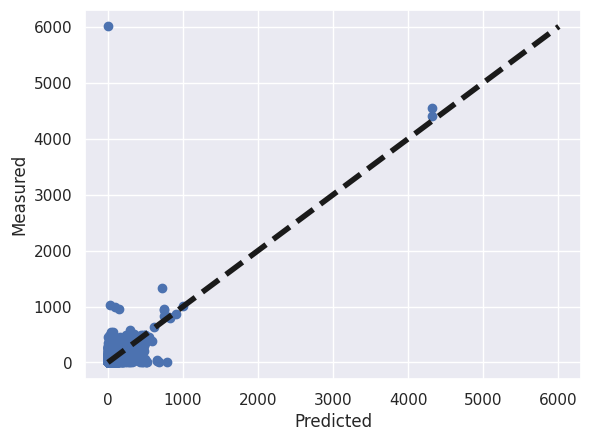

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,y_pred)))
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))
import matplotlib.pyplot as plt

plt.plot(y_pred, y_test, 'o')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw= 4)
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Split data into training and testing sets
X = df[['trip_distance', 'passenger_count', 'rate_code', 'trip_duration_seconds','speed','tolls_amount','tip_amount']]
y = df['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
base_models = [
    LinearRegression(),
    DecisionTreeRegressor(),
]

# Initialize meta-model
meta_model = LinearRegression()

# Generate predictions for meta features
meta_features = np.zeros((len(X_test), len(base_models)))

# Train base models and generate meta features
for i, model in enumerate(base_models):
    model.fit(X_train, y_train)
    meta_features[:, i] = model.predict(X_test)

# Train meta-model on meta features
meta_model.fit(meta_features, y_test)

# Generate meta features for test data
meta_features_test = np.zeros((len(X_test), len(base_models)))
for i, model in enumerate(base_models):
    meta_features_test[:, i] = model.predict(X_test)

# Make final predictions using meta-model
final_predictions = meta_model.predict(meta_features_test)

# Evaluate final predictions
mse = mean_squared_error(y_test, final_predictions)
print("Mean Squared Error (MSE) of Stacked Model:", mse)


Mean Squared Error (MSE) of Stacked Model: 30.86488736866704


In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, final_predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, final_predictions)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 30.86488736866704
Root Mean Squared Error (RMSE): 5.555617640610902
R-squared (R2) Score: 0.9319658236240775


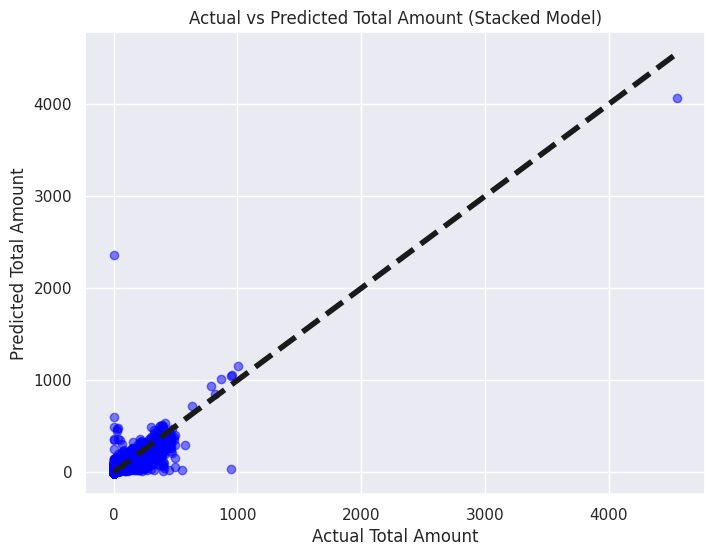

In [6]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Total Amount')
plt.ylabel('Predicted Total Amount')
plt.title('Actual vs Predicted Total Amount (Stacked Model)')
plt.grid(True)
plt.show()


Epoch 1/10
123511/123511 [==============================] - 311s 3ms/step - loss: 12770.0664 - val_loss: 105.0143
Epoch 2/10
123511/123511 [==============================] - 287s 2ms/step - loss: 11805.2539 - val_loss: 107.0956
Epoch 3/10
123511/123511 [==============================] - 281s 2ms/step - loss: 11828.5889 - val_loss: 98.4296
Epoch 4/10
123511/123511 [==============================] - 312s 3ms/step - loss: 11788.5049 - val_loss: 111.4317
Epoch 5/10
123511/123511 [==============================] - 294s 2ms/step - loss: 11767.2051 - val_loss: 99.1481
Epoch 6/10
123511/123511 [==============================] - 304s 2ms/step - loss: 11817.5166 - val_loss: 99.2064
Epoch 7/10
123511/123511 [==============================] - 280s 2ms/step - loss: 11739.2432 - val_loss: 95.0225
Epoch 8/10
123511/123511 [==============================] - 301s 2ms/step - loss: 11749.9600 - val_loss: 102.0562
Epoch 9/10
123511/123511 [==============================] - 280s 2ms/step - loss: 11776.5605

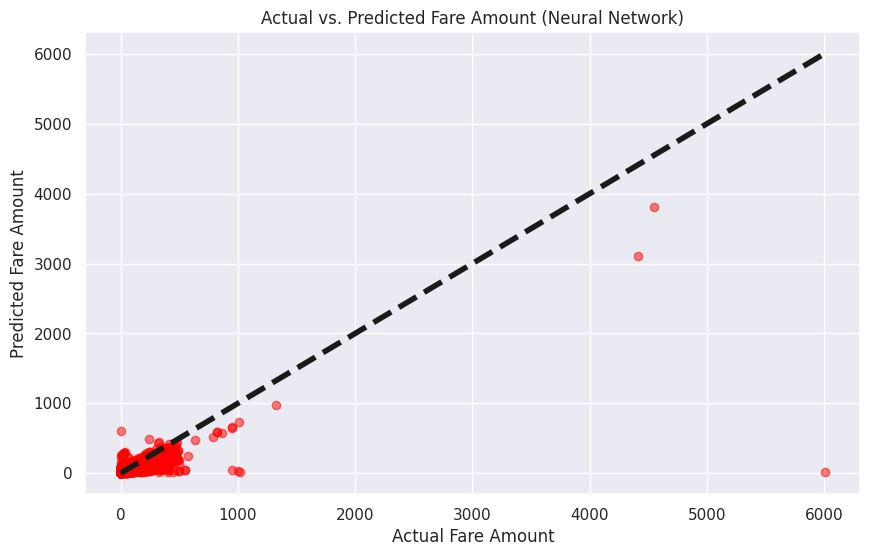

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 64 neurons and ReLU activation
    Dropout(0.2),  # Dropout layer for regularization
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
    Dense(1)  # Output layer with 1 neuron (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on the testing data
y_pred_nn = model.predict(X_test)

# Calculate evaluation metrics
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Print evaluation metrics
print("Mean Absolute Error (MAE) :", mae_nn)
print("Mean Squared Error (MSE) :", mse_nn)
print("Root Mean Squared Error (RMSE) :", rmse_nn)
print("R-squared (R2) Score :", r2_nn)

# Visualize predicted vs. actual fares
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, color='red', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs. Predicted Fare Amount (Neural Network)')
plt.show()
